In [ ]:
# Systems Immunogenetics Project

## WNV Cleaning Steps

### McWeeney Lab, Oregon Health & Science University

** Authors: Gabrielle Choonoo (choonoo@ohsu.edu) and Michael Mooney (mooneymi@ohsu.edu) **

## Introduction

This is the step-by-step process for cleaning the WNV data for Clinical Score.

Required Files:
* WNV Data: Processed Weight, Raw Clinical score
* WNV Data Dictionary
* Array Annotation
* This notebook (Clinical Score.ipynb): [[Download here]](https://raw.githubusercontent.com/gchoonoo/Buxco_notebook/master/notebook.ipynb)

Required R packages:
- `gdata`

**Note: this notebook can also be downloaded as an R script (only the code blocks seen below will be included): [[Download R script here]](https://raw.githubusercontent.com/gchoonoo/WNV_cleaning_scripts/master/clean_data.r)

** All code is available on GitHub: [https://github.com/gchoonoo/WNV_cleaning_scripts](https://github.com/gchoonoo/WNV_cleaning_scripts) **

# Read in Data

In [1]:
###############
# Read in Data
###############

library(gdata)

# Gale: Read in clinical score sheet
# Lund: Read in clinical score sheets and combine
# Lund Data Example:

# Set empty vector
data2 <- vector("list",length(dir("score")))

# Read in all new data and combine
for(i in 1:length(dir("score"))){
  #print(i)
  
  if(substring(dir("score")[i],1,1) == "C"){
    
    read.xls(xls=paste("score",dir("score")[i],sep="/"), sheet=1,stringsAsFactors=F) -> data2[[i]]
    
    data2[[i]][,c(4,1,2,3,8,7,9:37)] -> data2[[i]]
    
  }else{
    
    read.xls(xls=paste("score",dir("score")[i],sep="/"), sheet=1, skip=1, colClasses=c("NULL",rep(NA,35),"NULL","NULL","NULL"),stringsAsFactors=F) -> data2[[i]]
    
    days = gsub("d","D",gsub("\\.","",names(data2[[i]])[7:35]))
    
    names(data2[[i]]) <- c("UW_Line","ID","Mating","RIX_ID","Timepoint","Date_Infected",days)
  }
  
  new_cs = do.call(rbind,data2)      
}

if(length(unique(new_cs[,1])) == length(dir("score"))){
  print(paste("Read in", length(dir("score")),"files"))
}

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size



[1] "Read in 16 files"


# 1. Clean mating

In [2]:
# "X" changed to "x"
new_cs[,"Mating"] <- gsub("X","x",new_cs[,"Mating"])

# 2. Clean ID

In [3]:
new_cs[,"ID"] <- paste(new_cs[,"Mating"], new_cs[,"RIX_ID"],sep="_")

# 3. Add/remove columns and edit column names

In [4]:
# Add Lab, Data_Altered, Notes
    # Gale: Add Virus
# Lund: Add UWID, remove Sex 
new_cs$Lab <- "Lund"
new_cs$UWID <- NA
new_cs$Data_Altered <- NA
new_cs$Notes <- NA
new_cs[,!names(new_cs)%in%"Sex"] -> new_cs_v2

# 4. Annotate died early columns

In [5]:
# read in most current weight sheets
read.xls(xls="Lund_Weight_22-Mar-2016_final.xlsx", sheet=1,stringsAsFactors=F) -> lund_weight

weight_names = c("ID","Death_Date","Death_Euthanized", "Death_FoundInCage", "Died_of_Virus", "Died_from_Anesthesia")

# merge clinical score with weight with deaths columns only
merge(new_cs, lund_weight[,weight_names], by="ID",all.x=T) -> new_cs_v2

# clean timepoint
new_cs_v2[,"Timepoint"] <- as.numeric(as.character(gsub("d","",new_cs_v2[,"Timepoint"])))

# format date infected
new_cs_v2[grep("/",new_cs_v2[,"Date_Infected"]),"Date_Infected"] <- as.character(as.Date(new_cs_v2[grep("/",new_cs_v2[,"Date_Infected"]),"Date_Infected"], format="%m/%d/%y"))

new_cs_v2[,"Date_Infected"] <- as.Date(new_cs_v2[,"Date_Infected"], format="%Y-%m-%d")

# Create early death flags

# add putative death day
days = c("D0","D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15","D16","D17","D18","D19","D20","D21","D22","D23","D24","D25","D26","D27","D28")

# Annotate putative death day
new_cs_v2$putative_death_day <- sapply(1:dim(new_cs_v2)[1],function(x)suppressWarnings(max(as.numeric(as.character(gsub("D","",names(new_cs_v2[x,days][which(!is.na(new_cs_v2[x,days]))])))))))

# 5. Add Flag_weight_day 

In [6]:
# Timepoint is >= 3 more than putative death day (day the weights are recorded up to), (internal check)
new_cs_v2$Flag_Death_Day = NA

new_cs_v2[which(new_cs_v2[,"Timepoint"] - new_cs_v2[,"putative_death_day"]>=3 & is.na(new_cs_v2[,"Death_Euthanized"]) & is.na(new_cs_v2[,"Death_FoundInCage"])),"Flag_Death_Day"] <- TRUE
length(which(new_cs_v2[,"Timepoint"] - new_cs_v2[,"putative_death_day"]>=3 & is.na(new_cs_v2[,"Death_Euthanized"]) & is.na(new_cs_v2[,"Death_FoundInCage"]))) # no flags, set to false
new_cs_v2[which(new_cs_v2[,"Timepoint"] - new_cs_v2[,"putative_death_day"]>=3 & is.na(new_cs_v2[,"Death_Euthanized"]) & is.na(new_cs_v2[,"Death_FoundInCage"])),]
new_cs_v2[-which(new_cs_v2[,"Timepoint"] - new_cs_v2[,"putative_death_day"]>=3 & is.na(new_cs_v2[,"Death_Euthanized"]) & is.na(new_cs_v2[,"Death_FoundInCage"])),"Flag_Death_Day"] <- FALSE

[1] 49

,ID,UW_Line,Mating,RIX_ID,Timepoint,Date_Infected,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,Lab,UWID,Data_Altered,Notes,Death_Date,Death_Euthanized,Death_FoundInCage,Died_of_Virus,Died_from_Anesthesia,putative_death_day,Flag_Death_Day
1,15119x16521_39,96,15119x16521,39,21,2015-11-09,0,NA,NA,0,NA,NA,NA,0,0,1,1,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,11,TRUE
2,15119x16521_40,96,15119x16521,40,21,2015-11-09,0,NA,NA,0,NA,NA,NA,0,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,8,TRUE
3,15119x16521_42,96,15119x16521,42,21,2015-11-09,0,NA,NA,0,NA,NA,NA,0,0,0,0,0,0,0,0,NA,0,NA,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,18,TRUE
6,15119x16521_49,96,15119x16521,49,28,2015-11-23,0,NA,0,NA,NA,0,NA,NA,NA,1,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,10,TRUE
7,15119x16521_50,96,15119x16521,50,28,2015-11-23,0,NA,0,NA,NA,0,NA,NA,NA,0,0,0,0,0,0,NA,NA,NA,0,NA,NA,0,NA,NA,0,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,24,TRUE
9,15119x16521_65,96,15119x16521,65,28,2015-11-23,0,NA,0,NA,NA,0,NA,NA,NA,0,0,0,0,0,0,NA,NA,NA,0,NA,NA,0,NA,NA,0,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,24,TRUE
15,16513x8027_35,106,16513x8027,35,12,2016-01-08,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,0,TRUE
50,18018x3460_13,99,18018x3460,13,12,2015-10-28,0,NA,0,NA,NA,0,NA,NA,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,8,TRUE
56,18018x3460_43,99,18018x3460,43,28,2016-02-01,0,NA,NA,0,NA,NA,NA,0,NA,1,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,10,TRUE
57,18018x3460_47,99,18018x3460,47,21,2016-02-03,0,NA,0,NA,NA,NA,NA,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lund,NA,NA,NA,NA,NA,NA,NA,NA,7,TRUE


# 6. Add Flag_weight_date 

In [9]:
# death day > timepoint, (internal check)
new_cs_v2$Death_Date_greater_timepoint = NA

if(length(which(new_cs_v2[,"Death_Euthanized"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Death_FoundInCage"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_of_Virus"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_from_Anesthesia"] > new_cs_v2[,"Timepoint"])) == 0){
  new_cs_v2$Death_Date_greater_timepoint = FALSE
}else{
  new_cs_v2[which(new_cs_v2[,"Death_Euthanized"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Death_FoundInCage"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_of_Virus"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_from_Anesthesia"] > new_cs_v2[,"Timepoint"]),"Death_Date_greater_timepoint"] <- TRUE
  
  new_cs_v2[-which(new_cs_v2[,"Death_Euthanized"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Death_FoundInCage"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_of_Virus"] > new_cs_v2[,"Timepoint"] | new_cs_v2[,"Died_from_Anesthesia"] > new_cs_v2[,"Timepoint"]),"Death_Date_greater_timepoint"] <- FALSE
}

# 7. Alter data clinical score = 0 to NA past death day

In [10]:
# Set clinical score = NA for days past death date
# Based on died early column (where it's not equal to putative death day), sets clinical score to NA for days past died early column
if(length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"]))>0){
  for(i in 1:length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"]))){
    print(i)
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"])[i],"Data_Altered"] <- "Yes"
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"])[i],"Notes"] <- "CS past death day set to NA"
    cols = new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"])[i],"Death_Euthanized"] < as.numeric(as.character(gsub("D","",days)))
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_Euthanized"])[i],days][cols] <- NA
  }
}

if(length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"]))>0){
  for(i in 1:length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"]))){
    print(i)
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"])[i],"Data_Altered"] <- "Yes"
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"])[i],"Notes"] <- "CS past death day set to NA"
    cols = new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"])[i],"Death_FoundInCage"] < as.numeric(as.character(gsub("D","",days)))
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Death_FoundInCage"])[i],days][cols] <- NA
  }
}

if(length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"]))>0){
  for(i in 1:length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"]))){
    print(i)
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"])[i],"Data_Altered"] <- "Yes"
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"])[i],"Notes"] <- "CS past death day set to NA"
    cols = new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"])[i],"Died_from_Anesthesia"] < as.numeric(as.character(gsub("D","",days)))
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_from_Anesthesia"])[i],days][cols] <- NA
  }
}

if(length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"]))>0){
  for(i in 1:length(which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"]))){
    print(i)
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"])[i],"Data_Altered"] <- "Yes"
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"])[i],"Notes"] <- "CS past death day set to NA"
    cols = new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"])[i],"Died_of_Virus"] < as.numeric(as.character(gsub("D","",days)))
    new_cs_v2[which(new_cs_v2[,"putative_death_day"] != new_cs_v2[,"Died_of_Virus"])[i],days][cols] <- NA
  }
}

# annotate death date
new_cs_v2[,"Death_Date"] <- as.Date(new_cs_v2[,"Death_Date"])
new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == FALSE),"Death_Date"] <- as.Date(as.character(new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == FALSE),"Date_Infected"] + new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == FALSE),"Timepoint"]),format="%Y-%m-%d")

new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == TRUE),"Death_Date"] <- as.Date(as.character(new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == TRUE),"Date_Infected"] + new_cs_v2[which(is.na(new_cs_v2[,"Death_Date"]) & new_cs_v2[,"Flag_Death_Day"] == TRUE),"putative_death_day"]),format="%Y-%m-%d")

[1] 1


# 8. Order columns according to the data dictionary

In [13]:
mycols <- rep("NULL", 4)
mycols[1] <- NA

read.xls(xls="WNV_Data_Dictionary.xlsx", sheet="Clinical Score Data", colClasses=mycols) -> data_dict

# internal cols
internal_cols = c("putative_death_day","Flag_Death_Day", "Death_Date_greater_timepoint")
internal_cols_v2 = which(names(new_cs_v2) %in% internal_cols)

# order columns by data dictionary and add internal column at the end
new_cs_v2[,c(as.vector(unlist(sapply(data_dict[,1],function(x)which(x==names(new_cs_v2))))),internal_cols_v2)] -> new_cs_v3

# 9. "array_exists" column added to indicate availability of gene expression data

In [14]:
# append array annotation
read.table(file="all_expression_ids.txt") -> exp_id

new_cs_v3$array_exists = NA
new_cs_v3[as.vector(unlist(sapply(exp_id[,1],function(x)which(x==new_cs_v3[,1])))),"array_exists"] <- "Yes"
new_cs_v3[-as.vector(unlist(sapply(exp_id[,1],function(x)which(x==new_cs_v3[,1])))),"array_exists"] <- "No"

# 10. Update Data: Add flags_checked column

In [15]:
# read in full version
read.xls(xls="Lund_Scores_22-Mar-2016_final.xlsx", sheet=1,stringsAsFactors=F) -> cs_full

# remove any lines from full that are in updated data
remove_lines = intersect(cs_full[,"UW_Line"], new_cs_v3[,"UW_Line"])

# no updated lines
length(remove_lines) == 0
cs_full$flags_checked = TRUE
new_cs_v3$flags_checked = FALSE

# clean dates
cs_full[,"Death_Date"] <- as.Date(cs_full[,"Death_Date"])
cs_full[,"Date_Infected"] <- as.Date(cs_full[,"Date_Infected"])
new_cs_v3[,"Death_Date"] <- as.Date(new_cs_v3[,"Death_Date"])
new_cs_v3[,"Date_Infected"] <- as.Date(new_cs_v3[,"Date_Infected"])

# merge with full version, virus gets annotated here, fill in any NA from weight sheets or considered WNV if 'm' is not appended to timepoint
merge(cs_full, new_cs_v3, by=intersect(names(cs_full),names(new_cs_v3)),all=T) -> cs_full_v2
cs_full_v2[which(cs_full_v2[,"flags_checked"]),c("putative_death_day")] <- cs_full_v2[which(cs_full_v2[,"flags_checked"]),c("Timepoint")]
cs_full_v2[which(cs_full_v2[,"flags_checked"]),c("Flag_Death_Day")] <- FALSE
cs_full_v2[which(cs_full_v2[,"flags_checked"]),c("Death_Date_greater_timepoint")] <- FALSE

# re-order
cs_full_v2[,c(as.vector(unlist(sapply(data_dict[,1],function(x)which(x==names(cs_full_v2))))),internal_cols_v2)] -> cs_full_v3

[1] TRUE

# 11. Make specific alterations listed in the Readme. 

In [ ]:
# Make any manual corrections needed

# Example Plot

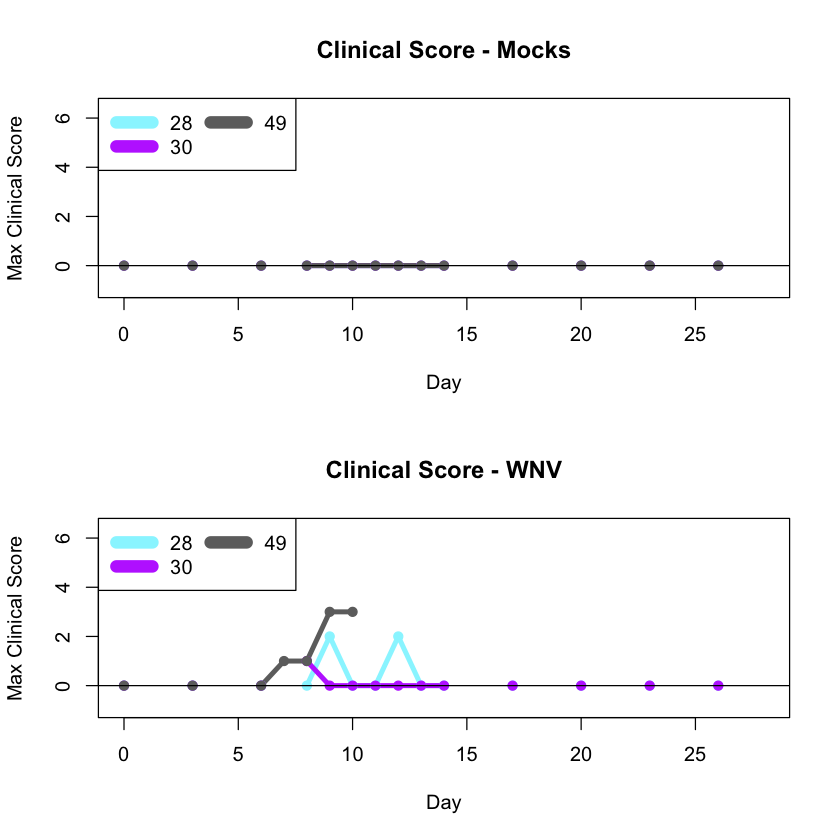

In [17]:
cs_time_plot = function(uw_lines, cs_cols=clinical_scores, mocks=FALSE, col=NULL,...) {
  y_cs = aggregate(cs_full_v2[, cs_cols], list(cs_full_v2$UW_Line, cs_full_v2$Virus), max, na.rm=T)
  colnames(y_cs) = c('line','virus',cs_cols)
  n_cols = floor(length(uw_lines)/3) + ceiling((length(uw_lines)%%3)/3)
  xvals = c(0:28)
  
  if (mocks) {
    #col = col[which(uw_lines %in% y_cs$line[y_cs$line %in% uw_lines & y_cs$virus=='Mock'])]
    par(mfrow=c(2,1))
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='Mock',cs_cols]), type="l", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - Mocks", lty=1, lwd=4, col=col,...)
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='Mock',cs_cols]), type="p", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - Mocks", add=T, col=col)
    abline(h=0, col='black')
    legend('topleft', legend=y_cs$line[y_cs$line %in% uw_lines & y_cs$virus=='Mock'], lty=1, lwd=10, ncol=n_cols, col=col)
    
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='WNV',cs_cols]), type="l", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - WNV", lty=1, lwd=4, col=col,...)
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='WNV',cs_cols]), type="p", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - WNV", add=T, col=col,...)
    abline(h=0, col='black')
    legend('topleft', legend=y_cs$line[y_cs$line %in% uw_lines & y_cs$virus=='WNV'], lty=1, lwd=10, ncol=n_cols, col=col)
  } else {
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='WNV',cs_cols]), type="l", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - WNV", lty=1, lwd=4, col=col,...)
    matplot(xvals, t(y_cs[y_cs[,1] %in% uw_lines & y_cs$virus=='WNV',cs_cols]), type="p", pch=19, ylim=c(-1,6.5), ylab="Max Clinical Score", xlab="Day", main="Clinical Score - WNV", add=T, col=col,...)
    abline(h=0, col='black')
    legend('topleft', legend=y_cs$line[y_cs$line %in% uw_lines & y_cs$virus=='WNV'], lty=1, lwd=10, ncol=n_cols, col=col)
  }
}

suppressWarnings(cs_time_plot(uw_lines=c("30","49","21","28"), cs_cols=days, mocks=T,col=sample(colors(),4)))